# Assignment 1 - Algorithms and Data Structures Analysis

## What This Notebook Does

This notebook tests and compares different algorithms:
1. **UnionFind** - 4 different ways to solve the "connected components" problem
2. **3Sum** - 3 different ways to find triplets that sum to zero

## How to Use

1. **Run all cells** to see the performance analysis
2. **Check the plots** to see which algorithms are faster
3. **Look at the timing results** to understand Big O complexity

## What You'll See

- **Timing measurements** for different input sizes
- **Performance plots** showing which algorithms scale better
- **Real examples** of how the algorithms work


In [1]:
import sys

sys.path.append("../src")

import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from threesum import (
    generate_test_data,
    three_sum_brute_force,
    three_sum_optimized,
    three_sum_optimized_with_hash,
)
from unionfind import (
    QuickFind,
    QuickUnion,
    WeightedQuickUnion,
    WeightedQuickUnionPathCompression,
)

# Set style for better plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Set random seed for reproducible results
random.seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Libraries imported successfully!
Python version: 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:09:17) [GCC 11.2.0]
NumPy version: 2.0.1
Pandas version: 2.3.2
Matplotlib version: 3.10.5


In [2]:
def measure_unionfind_performance(
    uf_class, n: int, operations: list[tuple[int, int]]
) -> float:
    """
    Measure performance of UnionFind operations.

    Args:
        uf_class: UnionFind class to test
        n: Number of elements
        operations: List of (p, q) union operations

    Returns:
        Total execution time in seconds
    """
    uf = uf_class(n)
    start_time = time.time()

    for p, q in operations:
        uf.union(p, q)

    end_time = time.time()
    return end_time - start_time


def generate_unionfind_operations(n: int, num_operations: int) -> list[tuple[int, int]]:
    """Generate random union operations for testing."""
    operations = []
    for _ in range(num_operations):
        p = random.randint(0, n - 1)
        q = random.randint(0, n - 1)
        operations.append((p, q))
    return operations


def measure_threesum_performance(
    func, nums: list[int]
) -> tuple[list[tuple[int, int, int]], float]:
    """
    Measure performance of 3Sum algorithm.

    Args:
        func: 3Sum function to test
        nums: List of integers

    Returns:
        Tuple of (results, execution_time)
    """
    start_time = time.time()
    result = func(nums)
    end_time = time.time()
    return result, end_time - start_time


print("Performance measurement functions defined!")

Performance measurement functions defined!


In [3]:
# UnionFind Performance Analysis
print("=== UnionFind Performance Analysis ===")

# Test parameters
n_values = [100, 500, 1000, 2000, 5000]
num_operations = 1000

# UnionFind algorithms to test
uf_algorithms = [
    ("Quick Find", QuickFind),
    ("Quick Union", QuickUnion),
    ("Weighted Quick Union", WeightedQuickUnion),
    ("Weighted Quick Union with Path Compression", WeightedQuickUnionPathCompression),
]

# Store results
uf_results = []

for n in n_values:
    print(f"\nTesting with N = {n}")
    operations = generate_unionfind_operations(n, num_operations)

    for name, uf_class in uf_algorithms:
        try:
            execution_time = measure_unionfind_performance(uf_class, n, operations)
            uf_results.append(
                {
                    "Algorithm": name,
                    "N": n,
                    "Operations": num_operations,
                    "Time (s)": execution_time,
                }
            )
            print(f"  {name}: {execution_time:.6f}s")
        except Exception as e:
            print(f"  {name}: Error - {e}")

print(f"\nUnionFind analysis completed! {len(uf_results)} measurements taken.")

=== UnionFind Performance Analysis ===

Testing with N = 100
  Quick Find: 0.000219s
  Quick Union: 0.000520s
  Weighted Quick Union: 0.000148s
  Weighted Quick Union with Path Compression: 0.000172s

Testing with N = 500
  Quick Find: 0.004876s
  Quick Union: 0.001106s
  Weighted Quick Union: 0.000222s
  Weighted Quick Union with Path Compression: 0.000251s

Testing with N = 1000
  Quick Find: 0.016491s
  Quick Union: 0.000612s
  Weighted Quick Union: 0.000226s
  Weighted Quick Union with Path Compression: 0.000281s

Testing with N = 2000
  Quick Find: 0.036438s
  Quick Union: 0.000165s
  Weighted Quick Union: 0.000200s
  Weighted Quick Union with Path Compression: 0.000227s

Testing with N = 5000
  Quick Find: 0.087985s
  Quick Union: 0.000125s
  Weighted Quick Union: 0.000170s
  Weighted Quick Union with Path Compression: 0.000198s

UnionFind analysis completed! 20 measurements taken.


In [4]:
# 3Sum Performance Analysis
print("=== 3Sum Performance Analysis ===")

# Test parameters for 3Sum
array_sizes = [50, 100, 200, 500, 1000]
threesum_algorithms = [
    ("Brute Force", three_sum_brute_force),
    ("Optimized Two Pointers", three_sum_optimized),
    ("Hash Set", three_sum_optimized_with_hash),
]

# Store results
threesum_results = []

for size in array_sizes:
    print(f"\nTesting with array size = {size}")

    # Generate test data
    test_data = generate_test_data(size)

    for name, func in threesum_algorithms:
        try:
            results, execution_time = measure_threesum_performance(func, test_data)
            threesum_results.append(
                {
                    "Algorithm": name,
                    "Array Size": size,
                    "Time (s)": execution_time,
                    "Solutions Found": len(results),
                }
            )
            print(f"  {name}: {execution_time:.6f}s ({len(results)} solutions)")
        except Exception as e:
            print(f"  {name}: Error - {e}")

print(f"\n3Sum analysis completed! {len(threesum_results)} measurements taken.")

=== 3Sum Performance Analysis ===

Testing with array size = 50
  Brute Force: 0.000657s (71 solutions)
  Optimized Two Pointers: 0.000113s (49 solutions)
  Hash Set: 0.000344s (64 solutions)

Testing with array size = 100
  Brute Force: 0.005273s (612 solutions)
  Optimized Two Pointers: 0.000213s (295 solutions)
  Hash Set: 0.000768s (501 solutions)

Testing with array size = 200
  Brute Force: 0.040329s (4734 solutions)
  Optimized Two Pointers: 0.000594s (1132 solutions)
  Hash Set: 0.002895s (3765 solutions)

Testing with array size = 500
  Brute Force: 0.716704s (79605 solutions)
  Optimized Two Pointers: 0.002632s (4149 solutions)
  Hash Set: 0.023190s (55745 solutions)

Testing with array size = 1000
  Brute Force: 5.992316s (622063 solutions)
  Optimized Two Pointers: 0.005445s (5025 solutions)
  Hash Set: 0.099445s (384293 solutions)

3Sum analysis completed! 15 measurements taken.


=== Creating Performance Visualizations ===


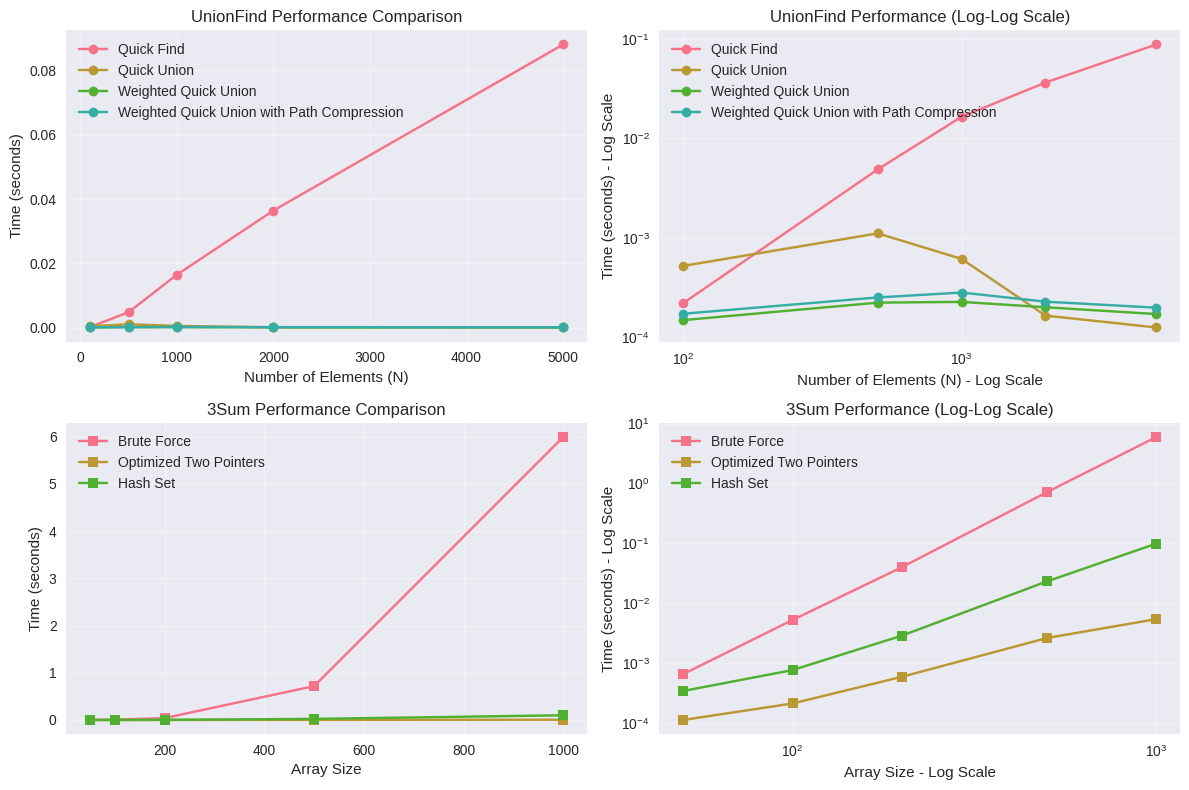

Visualizations created successfully!


In [5]:
# Visualization of Results
print("=== Creating Performance Visualizations ===")

# Convert results to DataFrames for easier plotting
uf_df = pd.DataFrame(uf_results)
threesum_df = pd.DataFrame(threesum_results)

# Create UnionFind performance plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
for algorithm in uf_df["Algorithm"].unique():
    data = uf_df[uf_df["Algorithm"] == algorithm]
    plt.plot(data["N"], data["Time (s)"], marker="o", label=algorithm)
plt.xlabel("Number of Elements (N)")
plt.ylabel("Time (seconds)")
plt.title("UnionFind Performance Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
for algorithm in uf_df["Algorithm"].unique():
    data = uf_df[uf_df["Algorithm"] == algorithm]
    plt.loglog(data["N"], data["Time (s)"], marker="o", label=algorithm)
plt.xlabel("Number of Elements (N) - Log Scale")
plt.ylabel("Time (seconds) - Log Scale")
plt.title("UnionFind Performance (Log-Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)

# Create 3Sum performance plot
plt.subplot(2, 2, 3)
for algorithm in threesum_df["Algorithm"].unique():
    data = threesum_df[threesum_df["Algorithm"] == algorithm]
    plt.plot(data["Array Size"], data["Time (s)"], marker="s", label=algorithm)
plt.xlabel("Array Size")
plt.ylabel("Time (seconds)")
plt.title("3Sum Performance Comparison")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
for algorithm in threesum_df["Algorithm"].unique():
    data = threesum_df[threesum_df["Algorithm"] == algorithm]
    plt.loglog(data["Array Size"], data["Time (s)"], marker="s", label=algorithm)
plt.xlabel("Array Size - Log Scale")
plt.ylabel("Time (seconds) - Log Scale")
plt.title("3Sum Performance (Log-Log Scale)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations created successfully!")